In [12]:
import matplotlib.pyplot as plt
import kagglehub
import numpy as np
import cv2

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support
from skimage.morphology import opening, closing, disk
from skimage.measure import label, regionprops

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from collections import Counter
from glob import glob

import warnings
warnings.filterwarnings('ignore')


In [2]:
path = kagglehub.dataset_download("meteahishali/aerial-imagery-for-standing-dead-tree-segmentation")
ROOT_DIR = path + '/USA_segmentation'

MASKS_ROOT_DIR = f'{ROOT_DIR}/masks'
NRG_IMAGES_ROOT_DIR = f'{ROOT_DIR}/NRG_images'
RGB_IMAGES_ROOT_DIR = f'{ROOT_DIR}/RGB_images'

rgb_paths = sorted(glob(f'{RGB_IMAGES_ROOT_DIR}/*.png'))[:]
nrg_paths = sorted(glob(f'{NRG_IMAGES_ROOT_DIR}/*.png'))[:]
mask_paths = sorted(glob(f'{MASKS_ROOT_DIR}/*.png'))[:]

# Data Preprocessing and Feature Engineering

## Dataset Analysis Function: Stratified split for train (80%) and test (20%) set

In [23]:
def calculate_image_dead_tree_proportions(rgb_paths, nrg_paths, mask_paths, downsample=2):
    """
    Calculate the proportion of dead tree pixels in each image for stratification.
    This helps us understand the 'difficulty' and 'type' of each image.
    """
    proportions = []
    image_stats = []

    print("Analyzing dead tree proportions across all images...")

    for i in range(len(rgb_paths)):
        # Load and downsample mask
        msk = cv2.imread(mask_paths[i], cv2.IMREAD_GRAYSCALE)[::downsample, ::downsample]

        # Calculate statistics
        dead_pixels = np.sum(msk > 127)
        total_pixels = msk.size
        proportion = dead_pixels / total_pixels

        proportions.append(proportion)
        image_stats.append({
            'image_idx': i,
            'dead_pixels': dead_pixels,
            'total_pixels': total_pixels,
            'proportion': proportion
        })


    proportions = np.array(proportions)

    # Print summary statistics
    print(f"\nDataset Dead Tree Distribution Summary:")
    print(f"  Mean dead tree %: {np.mean(proportions)*100:.2f}%")
    print(f"  Median dead tree %: {np.median(proportions)*100:.2f}%")
    print(f"  Min dead tree %: {np.min(proportions)*100:.2f}%")
    print(f"  Max dead tree %: {np.max(proportions)*100:.2f}%")
    print(f"  Std dev: {np.std(proportions)*100:.2f}%")

    return proportions, image_stats

def create_stratification_bins(proportions):
    bins = np.digitize(proportions, bins=[0.05])
    bin_names = ['Healthy (0-5%)', 'Stressed (5%+)']

    return bins

## Image processing function

In [24]:
def merge_rgb_nrg_to_4band(rgb_path, nrg_path, downsample=1):
    """
    Merge RGB and NRG images to create a 4-band multispectral image.
    """
    rgb_img = cv2.imread(rgb_path)[::downsample, ::downsample]
    nrg_img = cv2.imread(nrg_path)[::downsample, ::downsample]

    if rgb_img.shape[:2] != nrg_img.shape[:2]:
        raise ValueError(f"Image dimensions don't match: RGB {rgb_img.shape[:2]} vs NRG {nrg_img.shape[:2]}")

    # Extract channels
    NIR = nrg_img[..., 0].astype(np.float32)
    B = rgb_img[..., 0].astype(np.float32)  # Blue
    G = rgb_img[..., 1].astype(np.float32)  # Green
    R = rgb_img[..., 2].astype(np.float32)  # Red

    # Create 4-band image: [NIR, R, G, B]
    four_band = np.stack([NIR, R, G, B], axis=-1)
    return four_band

## Pixel Extraction and Rebalancing Functions

In [25]:
import numpy as np
import cv2

def extract_features_8band(four_band_image: np.ndarray) -> np.ndarray:
    """
    Enhanced feature extraction with all 8 features
    Args:
        four_band_image: numpy array (H, W, 4) in [NIR, R, G, B] order
    Returns:
        Feature array (H, W, 8)
    """
    # Normalize to [0,1] and clip to valid range
    NIR = np.clip(four_band_image[..., 0] / 255.0, 0, 1)
    R   = np.clip(four_band_image[..., 1] / 255.0, 0, 1)
    G   = np.clip(four_band_image[..., 2] / 255.0, 0, 1)
    B   = np.clip(four_band_image[..., 3] / 255.0, 0, 1)

    # Basic bands
    features = [R, G, B, NIR]

    # Vegetation indices with NaN protection
    # NDVI
    ndvi_denom = NIR + R + 1e-8
    NDVI = np.where(ndvi_denom > 0, (NIR - R) / ndvi_denom, 0)

    # EVI - more complex, needs careful handling
    evi_denom = NIR + 6 * R - 7.5 * B + 1
    EVI = np.where(evi_denom != 0, 2.5 * (NIR - R) / evi_denom, 0)
    EVI = np.clip(EVI, -1, 1)  # EVI typically ranges from -1 to 1

    # SAVI
    savi_denom = NIR + R + 0.5
    SAVI = np.where(savi_denom > 0, 1.5 * (NIR - R) / savi_denom, 0)

    # GNDVI
    gndvi_denom = NIR + G + 1e-8
    GNDVI = np.where(gndvi_denom > 0, (NIR - G) / gndvi_denom, 0)

    features.extend([NDVI, EVI, SAVI, GNDVI])

    # Stack and ensure no NaN/inf values
    result = np.stack(features, axis=-1).astype(np.float32)
    result = np.nan_to_num(result, nan=0.0, posinf=1.0, neginf=-1.0)

    return result


def extract_pixels_with_rebalancing(train_idx, rgb_paths, nrg_paths, mask_paths,
                                   downsample=2, target_dead_ratio=0.3,
                                   max_total_pixels=1000000):
    """
    Extract pixels from training images and rebalance classes.
    Now uses all 8 features (R, G, B, NIR, NDVI, EVI, SAVI, GNDVI).
    Works with stratified image indices.
    """

    print("Phase 1: Extracting all pixels from stratified training images...")
    print("Features: R, G, B, NIR, NDVI, EVI, SAVI, GNDVI (8 features)")

    all_features = []
    all_labels = []
    image_sources = []

    # Extract pixels from all training images
    for img_idx, i in enumerate(train_idx):
        four_band = merge_rgb_nrg_to_4band(rgb_paths[i], nrg_paths[i], downsample)
        msk = cv2.imread(mask_paths[i], cv2.IMREAD_GRAYSCALE)[::downsample, ::downsample]

        # Extract all 8 spectral features using enhanced method
        features_8band = extract_features_8band(four_band)  # Shape: (H, W, 8)

        # Flatten to pixel-level features
        pix_feat = features_8band.reshape(-1, 8)  # Now 8 features instead of 5
        pix_lbl = (msk.reshape(-1) > 127).astype(int)
        pixel_sources = np.full(len(pix_lbl), img_idx)

        all_features.append(pix_feat)
        all_labels.append(pix_lbl)
        image_sources.append(pixel_sources)

        # Progress reporting
        dead_count = np.sum(pix_lbl == 1)
        total_count = len(pix_lbl)

        if img_idx % 10 == 0 or img_idx == len(train_idx) - 1:
            print(f"  Image {img_idx+1}/{len(train_idx)}: {total_count:,} pixels, "
                  f"{dead_count:,} dead ({dead_count/total_count*100:.2f}%)")

    # Concatenate all pixels
    X_all = np.vstack(all_features)
    y_all = np.concatenate(all_labels)
    sources_all = np.concatenate(image_sources)

    print(f"\nPhase 2: Class rebalancing within training set...")
    dead_pixels = np.sum(y_all == 1)
    total_pixels = len(y_all)
    print(f"Raw training pixels: {total_pixels:,}")
    print(f"Dead tree pixels: {dead_pixels:,} ({dead_pixels/total_pixels*100:.2f}%)")
    print(f"Background pixels: {total_pixels - dead_pixels:,}")

    # Apply rebalancing strategy
    dead_mask = (y_all == 1)
    background_mask = (y_all == 0)

    dead_indices = np.where(dead_mask)[0]
    background_indices = np.where(background_mask)[0]

    # Calculate target sample sizes
    max_dead_pixels = len(dead_indices)
    target_dead_pixels = min(max_dead_pixels, int(max_total_pixels * target_dead_ratio))
    target_background_pixels = min(len(background_indices), max_total_pixels - target_dead_pixels)

    print(f"Target dead tree pixels: {target_dead_pixels:,}")
    print(f"Target background pixels: {target_background_pixels:,}")

    # Sample pixels
    if len(dead_indices) <= target_dead_pixels:
        sampled_dead_indices = dead_indices
        print(f"Using all {len(dead_indices):,} available dead tree pixels")
    else:
        sampled_dead_indices = np.random.choice(dead_indices, size=target_dead_pixels, replace=False)
        print(f"Randomly sampled {target_dead_pixels:,} dead tree pixels")

    sampled_background_indices = np.random.choice(background_indices, size=target_background_pixels, replace=False)
    print(f"Randomly sampled {target_background_pixels:,} background pixels")

    # Combine and shuffle
    final_indices = np.concatenate([sampled_dead_indices, sampled_background_indices])
    shuffle_indices = np.random.permutation(len(final_indices))

    X_balanced = X_all[final_indices[shuffle_indices]]
    y_balanced = y_all[final_indices[shuffle_indices]]

    print(f"\nFinal rebalanced training set:")
    final_dead = np.sum(y_balanced == 1)
    final_total = len(y_balanced)
    print(f"Total pixels: {final_total:,}")
    print(f"Dead tree pixels: {final_dead:,} ({final_dead/final_total*100:.1f}%)")
    print(f"Background pixels: {final_total - final_dead:,} ({(final_total - final_dead)/final_total*100:.1f}%)")
    print(f"Feature dimensions: {X_balanced.shape}")

    return X_balanced, y_balanced, msk


def extract_pixels(idxs, rgb_paths, nrg_paths, mask_paths, downsample=2):
    """
    Extract pixels maintaining natural class distribution (for test set).
    Now uses all 8 features (R, G, B, NIR, NDVI, EVI, SAVI, GNDVI).
    """
    features = []
    labels = []

    print("Extracting test pixels with natural class distribution...")
    print("Features: R, G, B, NIR, NDVI, EVI, SAVI, GNDVI (8 features)")

    for img_idx, i in enumerate(idxs):
        four_band = merge_rgb_nrg_to_4band(rgb_paths[i], nrg_paths[i], downsample)
        msk = cv2.imread(mask_paths[i], cv2.IMREAD_GRAYSCALE)[::downsample, ::downsample]

        # Extract all 8 spectral features using enhanced method
        features_8band = extract_features_8band(four_band)  # Shape: (H, W, 8)

        # Flatten to pixel-level features
        pix_feat = features_8band.reshape(-1, 8)  # Now 8 features instead of 5
        pix_lbl = (msk.reshape(-1) > 127).astype(int)

        features.append(pix_feat)
        labels.append(pix_lbl)

        # Progress reporting
        if img_idx % 5 == 0 or img_idx == len(idxs) - 1:
            dead_count = np.sum(pix_lbl == 1)
            total_count = len(pix_lbl)
            print(f"  Image {img_idx+1}/{len(idxs)}: {total_count:,} pixels, "
                  f"{dead_count:,} dead ({dead_count/total_count*100:.2f}%)")

    X = np.vstack(features)
    y = np.concatenate(labels)

    print(f"\nTest set summary:")
    print(f"Total pixels: {len(y):,}")
    print(f"Dead tree pixels: {np.sum(y==1):,} ({np.sum(y==1)/len(y)*100:.2f}%)")
    print(f"Background pixels: {np.sum(y==0):,} ({np.sum(y==0)/len(y)*100:.2f}%)")
    print(f"Feature dimensions: {X.shape}")

    return X, y

In [26]:
# Calculate dead tree proportions for each image
proportions, image_stats = calculate_image_dead_tree_proportions(
    rgb_paths, nrg_paths, mask_paths, downsample=2
)

# Create stratification bins (try 'adaptive', 'quantile', or 'fixed')
stratification_bins = create_stratification_bins(proportions)

Analyzing dead tree proportions across all images...

Dataset Dead Tree Distribution Summary:
  Mean dead tree %: 1.88%
  Median dead tree %: 1.33%
  Min dead tree %: 0.00%
  Max dead tree %: 12.63%
  Std dev: 1.77%


In [27]:
# Stratified train-test split at image level
all_indices = np.arange(len(rgb_paths))
train_idx, test_idx = train_test_split(
    all_indices,
    test_size=0.20,
    random_state=42,
    stratify=stratification_bins
)

print(f"\nImage-level stratified split:")
print(f"Training images: {len(train_idx)}")
print(f"Test images: {len(test_idx)}")

# Verify stratification worked
print(f"\nStratification verification:")
for bin_val in np.unique(stratification_bins):
    train_count = np.sum(stratification_bins[train_idx] == bin_val)
    test_count = np.sum(stratification_bins[test_idx] == bin_val)
    total_count = np.sum(stratification_bins == bin_val)
    print(f"  Bin {bin_val}: Train={train_count}, Test={test_count}, "
          f"Train%={train_count/total_count*100:.1f}%")


Image-level stratified split:
Training images: 355
Test images: 89

Stratification verification:
  Bin 0: Train=333, Test=83, Train%=80.0%
  Bin 1: Train=22, Test=6, Train%=78.6%


In [28]:
# Extract and rebalance training pixels
X_train, y_train, mask = extract_pixels_with_rebalancing(
    train_idx, rgb_paths, nrg_paths, mask_paths,
    downsample=2,
    target_dead_ratio=0.3,
    max_total_pixels=1000000
)

Phase 1: Extracting all pixels from stratified training images...
Features: R, G, B, NIR, NDVI, EVI, SAVI, GNDVI (8 features)
  Image 1/355: 39,999 pixels, 402 dead (1.01%)
  Image 11/355: 54,056 pixels, 274 dead (0.51%)
  Image 21/355: 42,435 pixels, 1,461 dead (3.44%)
  Image 31/355: 30,624 pixels, 1,446 dead (4.72%)
  Image 41/355: 29,736 pixels, 205 dead (0.69%)
  Image 51/355: 35,696 pixels, 176 dead (0.49%)
  Image 61/355: 33,440 pixels, 195 dead (0.58%)
  Image 71/355: 34,595 pixels, 294 dead (0.85%)
  Image 81/355: 41,989 pixels, 544 dead (1.30%)
  Image 91/355: 47,740 pixels, 3,413 dead (7.15%)
  Image 101/355: 31,842 pixels, 1,244 dead (3.91%)
  Image 111/355: 39,402 pixels, 297 dead (0.75%)
  Image 121/355: 38,592 pixels, 0 dead (0.00%)
  Image 131/355: 30,788 pixels, 315 dead (1.02%)
  Image 141/355: 30,561 pixels, 272 dead (0.89%)
  Image 151/355: 31,675 pixels, 175 dead (0.55%)
  Image 161/355: 34,176 pixels, 747 dead (2.19%)
  Image 171/355: 31,320 pixels, 217 dead (0.69

In [29]:
# Extract test pixels (natural distribution)
X_test, y_test = extract_pixels(test_idx, rgb_paths, nrg_paths, mask_paths, downsample=2)

Extracting test pixels with natural class distribution...
Features: R, G, B, NIR, NDVI, EVI, SAVI, GNDVI (8 features)
  Image 1/89: 35,880 pixels, 615 dead (1.71%)
  Image 6/89: 95,456 pixels, 602 dead (0.63%)
  Image 11/89: 35,910 pixels, 472 dead (1.31%)
  Image 16/89: 31,486 pixels, 75 dead (0.24%)
  Image 21/89: 38,024 pixels, 588 dead (1.55%)
  Image 26/89: 28,552 pixels, 623 dead (2.18%)
  Image 31/89: 47,300 pixels, 767 dead (1.62%)
  Image 36/89: 30,967 pixels, 75 dead (0.24%)
  Image 41/89: 31,842 pixels, 988 dead (3.10%)
  Image 46/89: 35,820 pixels, 0 dead (0.00%)
  Image 51/89: 32,712 pixels, 475 dead (1.45%)
  Image 56/89: 42,432 pixels, 1,306 dead (3.08%)
  Image 61/89: 33,286 pixels, 232 dead (0.70%)
  Image 66/89: 50,400 pixels, 1,766 dead (3.50%)
  Image 71/89: 46,176 pixels, 323 dead (0.70%)
  Image 76/89: 24,786 pixels, 356 dead (1.44%)
  Image 81/89: 30,260 pixels, 226 dead (0.75%)
  Image 86/89: 43,884 pixels, 190 dead (0.43%)
  Image 89/89: 28,552 pixels, 412 dead

In [30]:
print(f"\n=== FINAL PIPELINE SUMMARY ===")
print(f"Training: {X_train.shape[0]:,} pixels ({len(train_idx)} images)")
print(f"Test: {X_test.shape[0]:,} pixels ({len(test_idx)} images)")
print(f"Features per pixel: {X_train.shape[1]}")
print("✓ Image-level stratification ensures diverse scenarios in both sets")
print("✓ Training set rebalanced for effective learning")
print("✓ Test set maintains realistic class distribution")


=== FINAL PIPELINE SUMMARY ===
Training: 1,000,000 pixels (355 images)
Test: 3,585,276 pixels (89 images)
Features per pixel: 8
✓ Image-level stratification ensures diverse scenarios in both sets
✓ Training set rebalanced for effective learning
✓ Test set maintains realistic class distribution


# Evaluation Metrics Function (mIoU, F1, percision, and recall)

In [37]:
import numpy as np
import cv2
from sklearn.metrics import precision_recall_fscore_support

def extract_features_8band_eval(four_band_image: np.ndarray) -> np.ndarray:
    """
    Enhanced feature extraction with all 8 features - SAME as training
    Args:
        four_band_image: numpy array (H, W, 4) in [NIR, R, G, B] order
    Returns:
        Feature array (H, W, 8)
    """
    # Normalize to [0,1] and clip to valid range
    NIR = np.clip(four_band_image[..., 0] / 255.0, 0, 1)
    R   = np.clip(four_band_image[..., 1] / 255.0, 0, 1)
    G   = np.clip(four_band_image[..., 2] / 255.0, 0, 1)
    B   = np.clip(four_band_image[..., 3] / 255.0, 0, 1)

    # Basic bands
    features = [R, G, B, NIR]

    # Vegetation indices with NaN protection
    # NDVI
    ndvi_denom = NIR + R + 1e-8
    NDVI = np.where(ndvi_denom > 0, (NIR - R) / ndvi_denom, 0)

    # EVI - more complex, needs careful handling
    evi_denom = NIR + 6 * R - 7.5 * B + 1
    EVI = np.where(evi_denom != 0, 2.5 * (NIR - R) / evi_denom, 0)
    EVI = np.clip(EVI, -1, 1)  # EVI typically ranges from -1 to 1

    # SAVI
    savi_denom = NIR + R + 0.5
    SAVI = np.where(savi_denom > 0, 1.5 * (NIR - R) / savi_denom, 0)

    # GNDVI
    gndvi_denom = NIR + G + 1e-8
    GNDVI = np.where(gndvi_denom > 0, (NIR - G) / gndvi_denom, 0)

    features.extend([NDVI, EVI, SAVI, GNDVI])

    # Stack and ensure no NaN/inf values
    result = np.stack(features, axis=-1).astype(np.float32)
    result = np.nan_to_num(result, nan=0.0, posinf=1.0, neginf=-1.0)

    return result


def iou(pred_mask: np.ndarray, true_mask: np.ndarray) -> float:
    """Original IoU function - works perfectly"""
    assert pred_mask.shape == true_mask.shape, f"Shape mismatch: {pred_mask.shape} vs {true_mask.shape}"
    intersection = np.logical_and(pred_mask, true_mask).sum()
    union        = np.logical_or(pred_mask, true_mask).sum()
    return intersection / (union + 1e-8)


def evaluate_model(
    model,
    idxs,
    rgb_paths,
    nrg_paths,
    mask_paths,
    downsample: int = 1,
    threshold: float = 0.5
):
    """
    Evaluate model using mIoU, F1, Precision, and Recall.
    CORRECTED: Now uses 8 features to match training pipeline.

    Returns:
        dict: Contains mIoU, precision, recall, f1 for dead tree detection
    """

    # Storage for image-level IoUs and pixel-level predictions
    ious = []
    all_true_labels = []
    all_pred_labels = []

    print(f"Evaluating model on {len(idxs)} images...")
    print("Using 8 features: R, G, B, NIR, NDVI, EVI, SAVI, GNDVI")

    for img_idx, i in enumerate(idxs):
        # Same image processing pipeline as training
        four_band = merge_rgb_nrg_to_4band(rgb_paths[i], nrg_paths[i], downsample)
        msk = cv2.imread(mask_paths[i], cv2.IMREAD_GRAYSCALE)[::downsample, ::downsample]

        # CORRECTED: Extract ALL 8 features (identical to training pipeline)
        features_8band = extract_features_8band_eval(four_band)  # Shape: (H, W, 8)
        h, w = features_8band.shape[:2]

        # Flatten to pixel-level features (8 features now)
        feats = features_8band.reshape(-1, 8)

        # Get predictions
        if hasattr(model, "predict_proba"):
            proba = model.predict_proba(feats)[:, 1]
            pred = (proba > threshold).astype(np.uint8)
        else:
            pred = model.predict(feats).astype(np.uint8)

        # Reshape masks
        pred_mask = pred.reshape(h, w)
        true_mask = (msk > 127).astype(np.uint8)

        # Compute IoU for this image
        iou_score = iou(pred_mask, true_mask)
        ious.append(iou_score)

        # Accumulate pixel-level predictions for global metrics
        all_true_labels.extend(true_mask.flatten())
        all_pred_labels.extend(pred_mask.flatten())

        # Progress reporting
        if img_idx % 20 == 0 or img_idx == len(idxs) - 1:
            dead_pixels = np.sum(true_mask)
            total_pixels = true_mask.size
            print(f"  Processed {img_idx + 1}/{len(idxs)} images... "
                  f"IoU: {iou_score:.3f}, Dead pixels: {dead_pixels:,}/{total_pixels:,}")

    # Compute mean IoU across all images
    mean_iou = float(np.mean(ious))

    # Compute precision, recall, F1 across all pixels
    all_true_labels = np.array(all_true_labels)
    all_pred_labels = np.array(all_pred_labels)

    # Get metrics for dead tree class (class 1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_true_labels, all_pred_labels, labels=[0, 1], average=None, zero_division=0
    )

    # Extract dead tree metrics (index 1)
    dead_tree_precision = precision[1] if len(precision) > 1 else 0.0
    dead_tree_recall = recall[1] if len(recall) > 1 else 0.0
    dead_tree_f1 = f1[1] if len(f1) > 1 else 0.0

    return {
        'mIoU': mean_iou,
        'precision': dead_tree_precision,
        'recall': dead_tree_recall,
        'f1': dead_tree_f1,
        'num_images': len(idxs),
        'total_dead_pixels': int(all_true_labels.sum()),
        'total_pixels': len(all_true_labels),
        'individual_ious': ious  # Added for detailed analysis
    }


def print_evaluation_results(results):
    """Print evaluation results in a clean format"""

    print("\n" + "="*60)
    print("DEAD TREE DETECTION - EVALUATION RESULTS (8 Features)")
    print("="*60)

    print(f"Images evaluated: {results['num_images']}")
    print(f"Total pixels: {results['total_pixels']:,}")
    print(f"Dead tree pixels: {results['total_dead_pixels']:,}")
    print(f"Dead tree pixel coverage: {results['total_dead_pixels']/results['total_pixels']*100:.2f}%")
    print()
    print(f"Mean IoU:  {results['mIoU']:.4f}")
    print(f"Precision: {results['precision']:.4f}")
    print(f"Recall:    {results['recall']:.4f}")
    print(f"F1-Score:  {results['f1']:.4f}")

    print("="*60)

# Model Training

## IOU evaluation and Classification Report (Random Forest)

In [34]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=4, class_weight=None, n_jobs=4, random_state=42)
rf_model.fit(X_train, y_train)

# Compare on test set
results_rf = evaluate_model(rf_model, test_idx, rgb_paths, nrg_paths, mask_paths)

Evaluating model on 89 images...
Using 8 features: R, G, B, NIR, NDVI, EVI, SAVI, GNDVI
  Processed 1/89 images... IoU: 0.002, Dead pixels: 2,497/143,520
  Processed 21/89 images... IoU: 0.272, Dead pixels: 2,375/152,096
  Processed 41/89 images... IoU: 0.052, Dead pixels: 3,976/126,655
  Processed 61/89 images... IoU: 0.118, Dead pixels: 910/133,144
  Processed 81/89 images... IoU: 0.104, Dead pixels: 908/120,700
  Processed 89/89 images... IoU: 0.139, Dead pixels: 1,658/113,864


In [43]:
print_evaluation_results(results_rf)


DEAD TREE DETECTION - EVALUATION RESULTS (8 Features)
Images evaluated: 89
Total pixels: 14,310,175
Dead tree pixels: 261,227
Dead tree pixel coverage: 1.83%

Mean IoU:  0.1283
Precision: 0.1564
Recall:    0.4565
F1-Score:  0.2329


Training MLP on 1,000,000 pixels...
Epoch  10: Train Loss: 0.4037, Val Loss: 0.3950
Epoch  20: Train Loss: 0.4020, Val Loss: 0.3948
Epoch  30: Train Loss: 0.4019, Val Loss: 0.3942
Epoch  40: Train Loss: 0.4014, Val Loss: 0.3935
Epoch  50: Train Loss: 0.4013, Val Loss: 0.3936
Training completed!


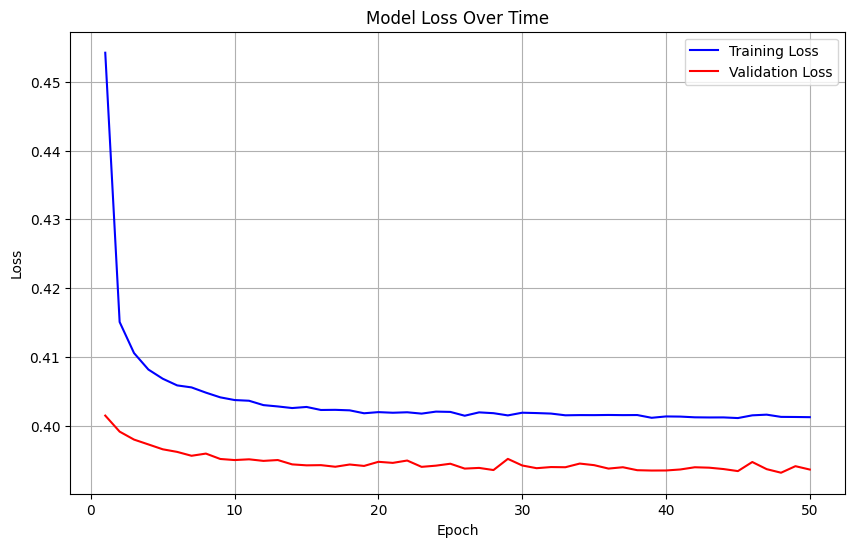

Evaluating model on 89 images...
Using 8 features: R, G, B, NIR, NDVI, EVI, SAVI, GNDVI
  Processed 1/89 images... IoU: 0.010, Dead pixels: 2,497/143,520
  Processed 21/89 images... IoU: 0.135, Dead pixels: 2,375/152,096
  Processed 41/89 images... IoU: 0.071, Dead pixels: 3,976/126,655
  Processed 61/89 images... IoU: 0.056, Dead pixels: 910/133,144
  Processed 81/89 images... IoU: 0.073, Dead pixels: 908/120,700
  Processed 89/89 images... IoU: 0.118, Dead pixels: 1,658/113,864


In [41]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
from typing import Tuple, List
import warnings
warnings.filterwarnings('ignore')

class CropHealthMLP(nn.Module):
    def __init__(self,
                 input_size: int = 8,
                 hidden_sizes: List[int] = [64, 32, 16],
                 dropout_rate: float = 0.3,
                 use_batch_norm: bool = True):
        """
        Initialize the MLP architecture.

        Args:
            input_size: Number of input features (5 for R, G, B, NIR, NDVI)
            hidden_sizes: List of hidden layer sizes
            dropout_rate: Dropout probability for regularization
            use_batch_norm: Whether to use batch normalization
        """
        super(CropHealthMLP, self).__init__()

        # Build the network layers
        layers = []
        current_size = input_size

        for i, hidden_size in enumerate(hidden_sizes):
            layers.append(nn.Linear(current_size, hidden_size))

            if use_batch_norm:
                layers.append(nn.BatchNorm1d(hidden_size))

            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))

            current_size = hidden_size

        # Output layer for binary classification
        layers.append(nn.Linear(current_size, 1))

        self.network = nn.Sequential(*layers)
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize network weights using Xavier initialization."""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_uniform_(module.weight)
                nn.init.constant_(module.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through the network."""
        return self.network(x)


class CropHealthTrainer:
    def __init__(self, model: CropHealthMLP, device: str = 'cpu'):
        """
        Initialize the trainer with a model and computing device.

        Args:
            model: The MLP model to train
            device: Computing device ('cpu' or 'cuda')
        """
        self.model = model.to(device)
        self.device = device
        self.scaler = StandardScaler()
        self.training_history = {'train_loss': [], 'val_loss': []}

        # Loss and optimizer
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', patience=10, factor=0.5, verbose=False
        )

    def fit(self, X_train: np.ndarray, y_train: np.ndarray,
            validation_split: float = 0.2, epochs: int = 100,
            batch_size: int = 1024, patience: int = 15):
        """
        Train the model - sklearn-style interface.

        Args:
            X_train: Training features of shape (n_samples, 5)
            y_train: Training labels of shape (n_samples,)
            validation_split: Fraction of data to use for validation
            epochs: Maximum number of training epochs
            batch_size: Batch size for training
            patience: Early stopping patience
        """
        print(f"Training MLP on {len(X_train):,} pixels...")

        # Split data for validation
        n_val = int(len(X_train) * validation_split)
        indices = np.random.permutation(len(X_train))
        val_idx, train_idx = indices[:n_val], indices[n_val:]

        X_train_split = X_train[train_idx]
        y_train_split = y_train[train_idx]
        X_val = X_train[val_idx]
        y_val = y_train[val_idx]

        # Normalize features
        X_train_scaled = self.scaler.fit_transform(X_train_split)
        X_val_scaled = self.scaler.transform(X_val)

        # Convert to PyTorch tensors
        X_train_tensor = torch.FloatTensor(X_train_scaled)
        y_train_tensor = torch.FloatTensor(y_train_split).unsqueeze(1)
        X_val_tensor = torch.FloatTensor(X_val_scaled)
        y_val_tensor = torch.FloatTensor(y_val).unsqueeze(1)

        # Create data loaders
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Training loop
        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(epochs):
            # Training phase
            self.model.train()
            total_train_loss = 0

            for batch_features, batch_labels in train_loader:
                batch_features = batch_features.to(self.device)
                batch_labels = batch_labels.to(self.device)

                self.optimizer.zero_grad()
                outputs = self.model(batch_features)
                loss = self.criterion(outputs, batch_labels)
                loss.backward()
                self.optimizer.step()

                total_train_loss += loss.item()

            # Validation phase
            self.model.eval()
            total_val_loss = 0

            with torch.no_grad():
                for batch_features, batch_labels in val_loader:
                    batch_features = batch_features.to(self.device)
                    batch_labels = batch_labels.to(self.device)

                    outputs = self.model(batch_features)
                    loss = self.criterion(outputs, batch_labels)
                    total_val_loss += loss.item()

            avg_train_loss = total_train_loss / len(train_loader)
            avg_val_loss = total_val_loss / len(val_loader)

            self.training_history['train_loss'].append(avg_train_loss)
            self.training_history['val_loss'].append(avg_val_loss)

            # Update learning rate
            self.scheduler.step(avg_val_loss)

            # Print progress every 10 epochs
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1:3d}: Train Loss: {avg_train_loss:.4f}, "
                      f"Val Loss: {avg_val_loss:.4f}")

            # Early stopping
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
                # Save best model state
                best_model_state = self.model.state_dict().copy()
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

        # Load best model
        self.model.load_state_dict(best_model_state)
        print("Training completed!")

        return self

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Predict class probabilities - sklearn-style interface.

        Args:
            X: Features of shape (n_samples, 5)

        Returns:
            Probabilities of shape (n_samples, 2) for [healthy, dead]
        """
        self.model.eval()

        # Normalize features
        X_scaled = self.scaler.transform(X)
        X_tensor = torch.FloatTensor(X_scaled).to(self.device)

        with torch.no_grad():
            # Get predictions in batches to handle large datasets
            batch_size = 10000
            probabilities = []

            for i in range(0, len(X_tensor), batch_size):
                batch = X_tensor[i:i+batch_size]
                logits = self.model(batch)
                dead_proba = torch.sigmoid(logits).cpu().numpy().flatten()
                healthy_proba = 1.0 - dead_proba
                batch_proba = np.column_stack([healthy_proba, dead_proba])
                probabilities.append(batch_proba)

            return np.vstack(probabilities)

    def predict(self, X: np.ndarray, threshold: float = 0.5) -> np.ndarray:
        """
        Predict class labels - sklearn-style interface.

        Args:
            X: Features of shape (n_samples, 5)
            threshold: Classification threshold

        Returns:
            Binary predictions of shape (n_samples,)
        """
        probabilities = self.predict_proba(X)
        return (probabilities[:, 1] > threshold).astype(np.uint8)


    def plot_training_history(self):
        """Plot training progress."""
        if not self.training_history['train_loss']:
            print("No training history to plot.")
            return

        plt.figure(figsize=(10, 6))
        epochs = range(1, len(self.training_history['train_loss']) + 1)

        plt.plot(epochs, self.training_history['train_loss'], 'b-', label='Training Loss')
        plt.plot(epochs, self.training_history['val_loss'], 'r-', label='Validation Loss')
        plt.title('Model Loss Over Time')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.show()


if __name__ == "__main__":
    # Create model
    mlp = CropHealthMLP(
        input_size=8,
        hidden_sizes=[100, 50, 25],
        dropout_rate=0.3
    )

    # Create trainer
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    trainer = CropHealthTrainer(mlp, device=device)

    trainer.fit(X_train, y_train, epochs=50, batch_size=1024)

    # Make predictions
    predictions = trainer.predict(X_test)
    probabilities = trainer.predict_proba(X_test)

    # Plot training history
    trainer.plot_training_history()

    # For spatial evaluation with your existing function:
    results_spatial = evaluate_model(trainer, test_idx, rgb_paths, nrg_paths, mask_paths)


In [42]:
print_evaluation_results(results_spatial)


DEAD TREE DETECTION - EVALUATION RESULTS (8 Features)
Images evaluated: 89
Total pixels: 14,310,175
Dead tree pixels: 261,227
Dead tree pixel coverage: 1.83%

Mean IoU:  0.1185
Precision: 0.1314
Recall:    0.5120
F1-Score:  0.2091


In [38]:
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    eval_metric='aucpr',
    random_state=42,
    n_jobs=4
)
xgb_model.fit(X_train, y_train)

# Evaluate on test set using same function
print("Evaluating XGBoost...")
results_xgb = evaluate_model(xgb_model, test_idx, rgb_paths, nrg_paths, mask_paths)
print_evaluation_results(results_xgb)


Evaluating XGBoost...
Evaluating model on 89 images...
Using 8 features: R, G, B, NIR, NDVI, EVI, SAVI, GNDVI
  Processed 1/89 images... IoU: 0.011, Dead pixels: 2,497/143,520
  Processed 21/89 images... IoU: 0.129, Dead pixels: 2,375/152,096
  Processed 41/89 images... IoU: 0.058, Dead pixels: 3,976/126,655
  Processed 61/89 images... IoU: 0.063, Dead pixels: 910/133,144
  Processed 81/89 images... IoU: 0.078, Dead pixels: 908/120,700
  Processed 89/89 images... IoU: 0.123, Dead pixels: 1,658/113,864

DEAD TREE DETECTION - EVALUATION RESULTS (8 Features)
Images evaluated: 89
Total pixels: 14,310,175
Dead tree pixels: 261,227
Dead tree pixel coverage: 1.83%

Mean IoU:  0.1198
Precision: 0.1364
Recall:    0.5001
F1-Score:  0.2143


In [39]:
lgb_model = LGBMClassifier(
    n_estimators=100,
    max_depth=4,
    device='gpu',  # Use 'cpu' if GPU not available
    random_state=42,
    n_jobs=4,
    verbose=-1  # Suppress training output
)
lgb_model.fit(X_train, y_train)

# Evaluate on test set using same function
print("Evaluating LightGBM...")
results_lgb = evaluate_model(lgb_model, test_idx, rgb_paths, nrg_paths, mask_paths)
print_evaluation_results(results_lgb)

Evaluating LightGBM...
Evaluating model on 89 images...
Using 8 features: R, G, B, NIR, NDVI, EVI, SAVI, GNDVI
  Processed 1/89 images... IoU: 0.010, Dead pixels: 2,497/143,520
  Processed 21/89 images... IoU: 0.137, Dead pixels: 2,375/152,096
  Processed 41/89 images... IoU: 0.061, Dead pixels: 3,976/126,655
  Processed 61/89 images... IoU: 0.067, Dead pixels: 910/133,144
  Processed 81/89 images... IoU: 0.085, Dead pixels: 908/120,700
  Processed 89/89 images... IoU: 0.125, Dead pixels: 1,658/113,864

DEAD TREE DETECTION - EVALUATION RESULTS (8 Features)
Images evaluated: 89
Total pixels: 14,310,175
Dead tree pixels: 261,227
Dead tree pixel coverage: 1.83%

Mean IoU:  0.1225
Precision: 0.1410
Recall:    0.4935
F1-Score:  0.2193


## CNN Architecture (Spatial Data Analysis)

Creating improved model with dropout...
Extracting training patches...


Extracting patches: 100%|██████████| 355/355 [00:09<00:00, 37.51it/s]


Total patches: 7863 (pos: 970, neg: 6893)
Balancing...
Balanced: 2910 (pos: 970, neg: 1940)
Training with enhanced regularization...


Epoch 1 - Training: 100%|██████████| 291/291 [00:09<00:00, 31.88it/s]


Epoch 1: Train Loss: 0.7317, Train Acc: 0.8180, Val Loss: 0.2085, Val Acc: 0.9625, LR: 0.000200
  → New best model saved (val_loss: 0.2085)


Epoch 2 - Training: 100%|██████████| 291/291 [00:07<00:00, 39.73it/s]


Epoch 2: Train Loss: 0.2706, Train Acc: 0.9476, Val Loss: 0.1827, Val Acc: 0.9635, LR: 0.000200
  → New best model saved (val_loss: 0.1827)


Epoch 3 - Training: 100%|██████████| 291/291 [00:07<00:00, 41.34it/s]


Epoch 3: Train Loss: 0.2228, Train Acc: 0.9546, Val Loss: 0.1690, Val Acc: 0.9655, LR: 0.000200
  → New best model saved (val_loss: 0.1690)


Epoch 4 - Training: 100%|██████████| 291/291 [00:07<00:00, 38.89it/s]


Epoch 4: Train Loss: 0.2044, Train Acc: 0.9562, Val Loss: 0.1653, Val Acc: 0.9659, LR: 0.000200
  → New best model saved (val_loss: 0.1653)


Epoch 5 - Training: 100%|██████████| 291/291 [00:07<00:00, 41.51it/s]


Epoch 5: Train Loss: 0.1909, Train Acc: 0.9579, Val Loss: 0.1532, Val Acc: 0.9673, LR: 0.000200
  → New best model saved (val_loss: 0.1532)


Epoch 6 - Training: 100%|██████████| 291/291 [00:07<00:00, 40.40it/s]


Epoch 6: Train Loss: 0.1841, Train Acc: 0.9585, Val Loss: 0.1524, Val Acc: 0.9680, LR: 0.000200
  → New best model saved (val_loss: 0.1524)


Epoch 7 - Training: 100%|██████████| 291/291 [00:07<00:00, 37.75it/s]


Epoch 7: Train Loss: 0.1748, Train Acc: 0.9585, Val Loss: 0.1424, Val Acc: 0.9690, LR: 0.000200
  → New best model saved (val_loss: 0.1424)


Epoch 8 - Training: 100%|██████████| 291/291 [00:07<00:00, 38.20it/s]


Epoch 8: Train Loss: 0.1689, Train Acc: 0.9596, Val Loss: 0.1379, Val Acc: 0.9690, LR: 0.000200
  → New best model saved (val_loss: 0.1379)


Epoch 9 - Training: 100%|██████████| 291/291 [00:06<00:00, 42.47it/s]


Epoch 9: Train Loss: 0.1672, Train Acc: 0.9604, Val Loss: 0.1344, Val Acc: 0.9694, LR: 0.000200
  → New best model saved (val_loss: 0.1344)


Epoch 10 - Training: 100%|██████████| 291/291 [00:07<00:00, 39.79it/s]


Epoch 10: Train Loss: 0.1611, Train Acc: 0.9614, Val Loss: 0.1283, Val Acc: 0.9682, LR: 0.000200
  → New best model saved (val_loss: 0.1283)


Epoch 11 - Training: 100%|██████████| 291/291 [00:07<00:00, 40.85it/s]


Epoch 11: Train Loss: 0.1631, Train Acc: 0.9610, Val Loss: 0.1462, Val Acc: 0.9698, LR: 0.000200


Epoch 12 - Training: 100%|██████████| 291/291 [00:06<00:00, 41.75it/s]


Epoch 12: Train Loss: 0.1590, Train Acc: 0.9615, Val Loss: 0.1241, Val Acc: 0.9681, LR: 0.000200
  → New best model saved (val_loss: 0.1241)


Epoch 13 - Training: 100%|██████████| 291/291 [00:07<00:00, 39.69it/s]


Epoch 13: Train Loss: 0.1570, Train Acc: 0.9607, Val Loss: 0.1258, Val Acc: 0.9685, LR: 0.000200


Epoch 14 - Training: 100%|██████████| 291/291 [00:06<00:00, 41.71it/s]


Epoch 14: Train Loss: 0.1531, Train Acc: 0.9622, Val Loss: 0.1207, Val Acc: 0.9678, LR: 0.000200
  → New best model saved (val_loss: 0.1207)


Epoch 15 - Training: 100%|██████████| 291/291 [00:07<00:00, 40.28it/s]


Epoch 15: Train Loss: 0.1544, Train Acc: 0.9617, Val Loss: 0.1229, Val Acc: 0.9697, LR: 0.000200


Epoch 16 - Training: 100%|██████████| 291/291 [00:07<00:00, 39.10it/s]


Epoch 16: Train Loss: 0.1533, Train Acc: 0.9621, Val Loss: 0.1214, Val Acc: 0.9699, LR: 0.000200


Epoch 17 - Training: 100%|██████████| 291/291 [00:06<00:00, 42.00it/s]


Epoch 17: Train Loss: 0.1499, Train Acc: 0.9627, Val Loss: 0.1207, Val Acc: 0.9686, LR: 0.000200
  → New best model saved (val_loss: 0.1207)


Epoch 18 - Training: 100%|██████████| 291/291 [00:07<00:00, 40.46it/s]


Epoch 18: Train Loss: 0.1487, Train Acc: 0.9626, Val Loss: 0.1211, Val Acc: 0.9705, LR: 0.000200


Epoch 19 - Training: 100%|██████████| 291/291 [00:07<00:00, 39.46it/s]


Epoch 19: Train Loss: 0.1480, Train Acc: 0.9633, Val Loss: 0.1179, Val Acc: 0.9677, LR: 0.000200
  → New best model saved (val_loss: 0.1179)


Epoch 20 - Training: 100%|██████████| 291/291 [00:06<00:00, 42.04it/s]


Epoch 20: Train Loss: 0.1488, Train Acc: 0.9628, Val Loss: 0.1191, Val Acc: 0.9705, LR: 0.000200


Epoch 21 - Training: 100%|██████████| 291/291 [00:07<00:00, 39.97it/s]


Epoch 21: Train Loss: 0.1490, Train Acc: 0.9626, Val Loss: 0.1176, Val Acc: 0.9683, LR: 0.000200
  → New best model saved (val_loss: 0.1176)


Epoch 22 - Training: 100%|██████████| 291/291 [00:07<00:00, 39.19it/s]


Epoch 22: Train Loss: 0.1451, Train Acc: 0.9630, Val Loss: 0.1166, Val Acc: 0.9691, LR: 0.000200
  → New best model saved (val_loss: 0.1166)


Epoch 23 - Training: 100%|██████████| 291/291 [00:06<00:00, 41.83it/s]


Epoch 23: Train Loss: 0.1440, Train Acc: 0.9636, Val Loss: 0.1145, Val Acc: 0.9700, LR: 0.000200
  → New best model saved (val_loss: 0.1145)


Epoch 24 - Training: 100%|██████████| 291/291 [00:07<00:00, 39.90it/s]


Epoch 24: Train Loss: 0.1443, Train Acc: 0.9631, Val Loss: 0.1153, Val Acc: 0.9694, LR: 0.000200


Epoch 25 - Training: 100%|██████████| 291/291 [00:07<00:00, 39.49it/s]


Epoch 25: Train Loss: 0.1442, Train Acc: 0.9631, Val Loss: 0.1175, Val Acc: 0.9680, LR: 0.000200


Epoch 26 - Training: 100%|██████████| 291/291 [00:06<00:00, 41.62it/s]


Epoch 26: Train Loss: 0.1424, Train Acc: 0.9642, Val Loss: 0.1141, Val Acc: 0.9679, LR: 0.000200
  → New best model saved (val_loss: 0.1141)


Epoch 27 - Training: 100%|██████████| 291/291 [00:07<00:00, 39.53it/s]


Epoch 27: Train Loss: 0.1422, Train Acc: 0.9637, Val Loss: 0.1145, Val Acc: 0.9702, LR: 0.000200


Epoch 28 - Training: 100%|██████████| 291/291 [00:07<00:00, 39.29it/s]


Epoch 28: Train Loss: 0.1406, Train Acc: 0.9638, Val Loss: 0.1149, Val Acc: 0.9699, LR: 0.000200


Epoch 29 - Training: 100%|██████████| 291/291 [00:06<00:00, 42.33it/s]


Epoch 29: Train Loss: 0.1410, Train Acc: 0.9639, Val Loss: 0.1122, Val Acc: 0.9685, LR: 0.000200
  → New best model saved (val_loss: 0.1122)


Epoch 30 - Training: 100%|██████████| 291/291 [00:07<00:00, 38.66it/s]


Epoch 30: Train Loss: 0.1416, Train Acc: 0.9637, Val Loss: 0.1124, Val Acc: 0.9674, LR: 0.000200


Epoch 31 - Training: 100%|██████████| 291/291 [00:07<00:00, 39.80it/s]


Epoch 31: Train Loss: 0.1396, Train Acc: 0.9643, Val Loss: 0.1134, Val Acc: 0.9703, LR: 0.000200


Epoch 32 - Training: 100%|██████████| 291/291 [00:06<00:00, 42.35it/s]


Epoch 32: Train Loss: 0.1389, Train Acc: 0.9641, Val Loss: 0.1112, Val Acc: 0.9695, LR: 0.000200
  → New best model saved (val_loss: 0.1112)


Epoch 33 - Training: 100%|██████████| 291/291 [00:07<00:00, 39.91it/s]


Epoch 33: Train Loss: 0.1372, Train Acc: 0.9644, Val Loss: 0.1139, Val Acc: 0.9700, LR: 0.000200


Epoch 34 - Training: 100%|██████████| 291/291 [00:07<00:00, 39.37it/s]


Epoch 34: Train Loss: 0.1367, Train Acc: 0.9647, Val Loss: 0.1122, Val Acc: 0.9664, LR: 0.000200


Epoch 35 - Training: 100%|██████████| 291/291 [00:06<00:00, 42.02it/s]


Epoch 35: Train Loss: 0.1357, Train Acc: 0.9643, Val Loss: 0.1098, Val Acc: 0.9695, LR: 0.000200
  → New best model saved (val_loss: 0.1098)


Epoch 36 - Training: 100%|██████████| 291/291 [00:07<00:00, 39.64it/s]


Epoch 36: Train Loss: 0.1379, Train Acc: 0.9643, Val Loss: 0.1091, Val Acc: 0.9699, LR: 0.000200
  → New best model saved (val_loss: 0.1091)


Epoch 37 - Training: 100%|██████████| 291/291 [00:07<00:00, 39.86it/s]


Epoch 37: Train Loss: 0.1369, Train Acc: 0.9646, Val Loss: 0.1094, Val Acc: 0.9682, LR: 0.000200


Epoch 38 - Training: 100%|██████████| 291/291 [00:06<00:00, 42.27it/s]


Epoch 38: Train Loss: 0.1364, Train Acc: 0.9647, Val Loss: 0.1089, Val Acc: 0.9716, LR: 0.000200
  → New best model saved (val_loss: 0.1089)


Epoch 39 - Training: 100%|██████████| 291/291 [00:07<00:00, 39.59it/s]


Epoch 39: Train Loss: 0.1362, Train Acc: 0.9649, Val Loss: 0.1120, Val Acc: 0.9692, LR: 0.000200


Epoch 40 - Training: 100%|██████████| 291/291 [00:07<00:00, 40.75it/s]


Epoch 40: Train Loss: 0.1338, Train Acc: 0.9652, Val Loss: 0.1101, Val Acc: 0.9690, LR: 0.000200


Epoch 41 - Training: 100%|██████████| 291/291 [00:06<00:00, 41.85it/s]


Epoch 41: Train Loss: 0.1337, Train Acc: 0.9653, Val Loss: 0.1092, Val Acc: 0.9704, LR: 0.000200


Epoch 42 - Training: 100%|██████████| 291/291 [00:07<00:00, 39.59it/s]


Epoch 42: Train Loss: 0.1365, Train Acc: 0.9648, Val Loss: 0.1074, Val Acc: 0.9679, LR: 0.000200
  → New best model saved (val_loss: 0.1074)


Epoch 43 - Training: 100%|██████████| 291/291 [00:07<00:00, 41.12it/s]


Epoch 43: Train Loss: 0.1341, Train Acc: 0.9648, Val Loss: 0.1070, Val Acc: 0.9707, LR: 0.000200
  → New best model saved (val_loss: 0.1070)


Epoch 44 - Training: 100%|██████████| 291/291 [00:06<00:00, 42.14it/s]


Epoch 44: Train Loss: 0.1341, Train Acc: 0.9655, Val Loss: 0.1082, Val Acc: 0.9707, LR: 0.000200


Epoch 45 - Training: 100%|██████████| 291/291 [00:07<00:00, 39.59it/s]


Epoch 45: Train Loss: 0.1313, Train Acc: 0.9654, Val Loss: 0.1078, Val Acc: 0.9711, LR: 0.000200


Epoch 46 - Training: 100%|██████████| 291/291 [00:06<00:00, 42.40it/s]


Epoch 46: Train Loss: 0.1351, Train Acc: 0.9652, Val Loss: 0.1071, Val Acc: 0.9699, LR: 0.000200


Epoch 47 - Training: 100%|██████████| 291/291 [00:07<00:00, 40.62it/s]


Epoch 47: Train Loss: 0.1331, Train Acc: 0.9654, Val Loss: 0.1065, Val Acc: 0.9712, LR: 0.000200
  → New best model saved (val_loss: 0.1065)


Epoch 48 - Training: 100%|██████████| 291/291 [00:07<00:00, 39.89it/s]


Epoch 48: Train Loss: 0.1321, Train Acc: 0.9656, Val Loss: 0.1089, Val Acc: 0.9673, LR: 0.000200


Epoch 49 - Training: 100%|██████████| 291/291 [00:06<00:00, 41.82it/s]


Epoch 49: Train Loss: 0.1321, Train Acc: 0.9657, Val Loss: 0.1061, Val Acc: 0.9701, LR: 0.000200
  → New best model saved (val_loss: 0.1061)


Epoch 50 - Training: 100%|██████████| 291/291 [00:07<00:00, 39.98it/s]


Epoch 50: Train Loss: 0.1321, Train Acc: 0.9658, Val Loss: 0.1080, Val Acc: 0.9681, LR: 0.000200
Training complete. Best model loaded.
Plotting enhanced training history...


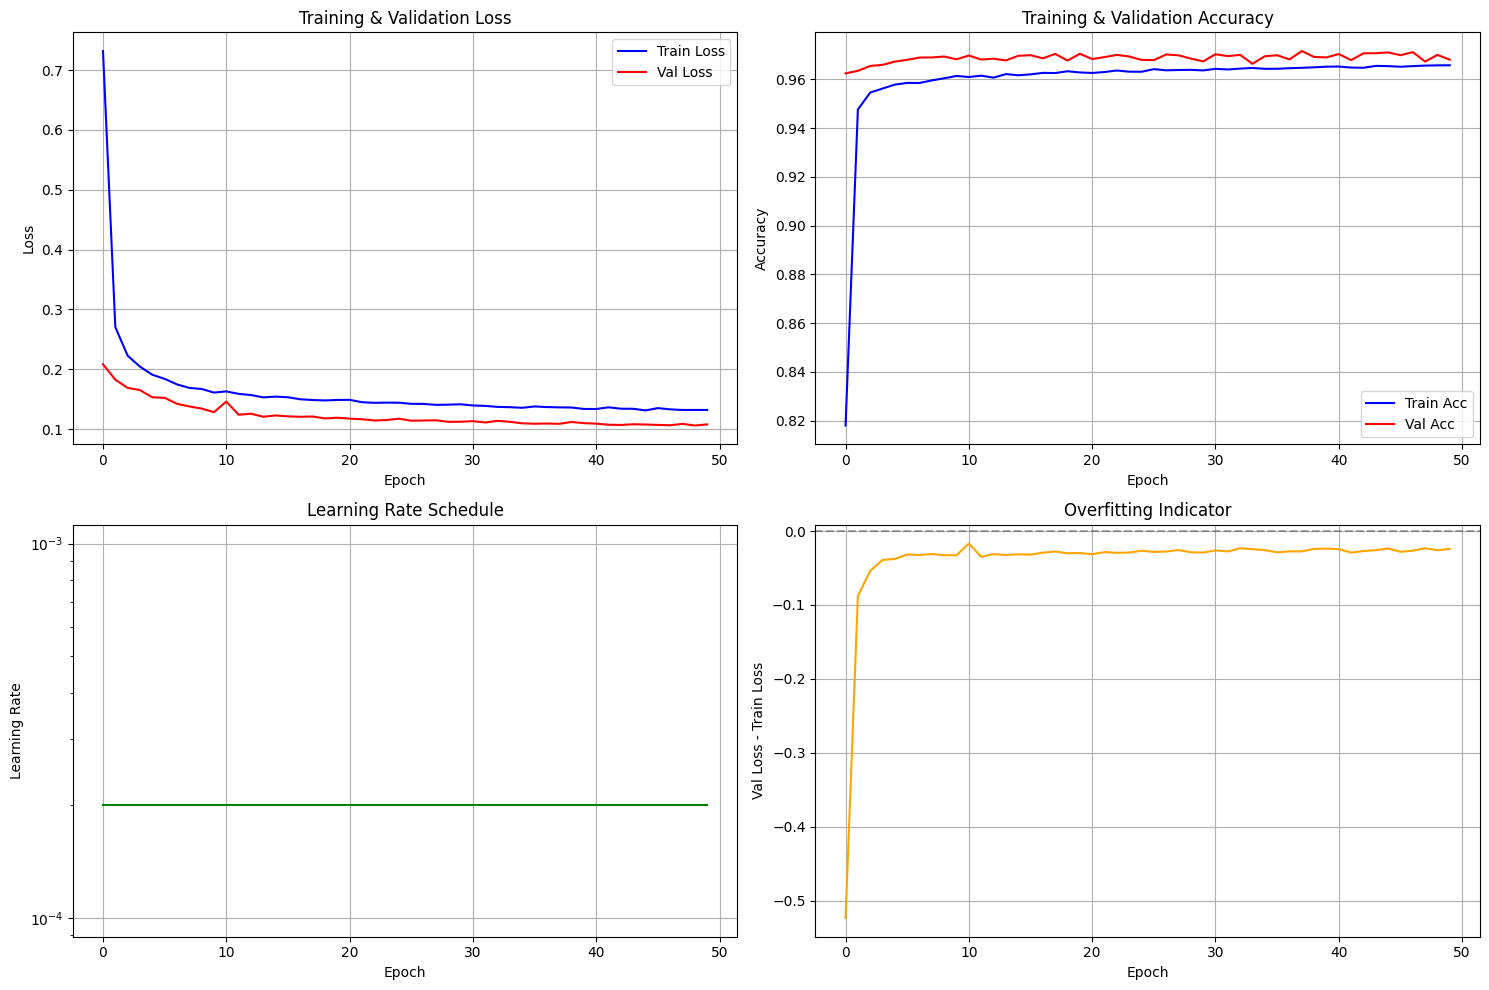

Evaluating...


Evaluating test images: 100%|██████████| 89/89 [00:11<00:00,  8.01it/s]


Results:
  mIoU: 0.3267956669074808
  precision: 0.47557166430928804
  recall: 0.4944773810070929
  f1: 0.4848402917032798
  num_images: 89


In [15]:
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
import os
from tqdm import tqdm
import random
from glob import glob


class EnhancedFeatureExtractor:
    @staticmethod
    def extract_features(four_band_image: np.ndarray) -> np.ndarray:
        """
        Args:
            four_band_image: numpy array (H, W, 4) in [NIR, R, G, B] order
        Returns:
            Feature array (H, W, 8)
        """
        # Normalize to [0,1] and clip to valid range
        NIR = np.clip(four_band_image[..., 0] / 255.0, 0, 1)
        R   = np.clip(four_band_image[..., 1] / 255.0, 0, 1)
        G   = np.clip(four_band_image[..., 2] / 255.0, 0, 1)
        B   = np.clip(four_band_image[..., 3] / 255.0, 0, 1)

        # Basic bands
        features = [R, G, B, NIR]

        # Vegetation indices with NaN protection
        # NDVI
        ndvi_denom = NIR + R + 1e-8
        NDVI = np.where(ndvi_denom > 0, (NIR - R) / ndvi_denom, 0)

        # EVI - more complex, needs careful handling
        evi_denom = NIR + 6 * R - 7.5 * B + 1
        EVI = np.where(evi_denom != 0, 2.5 * (NIR - R) / evi_denom, 0)
        EVI = np.clip(EVI, -1, 1)  # EVI typically ranges from -1 to 1

        # SAVI
        savi_denom = NIR + R + 0.5
        SAVI = np.where(savi_denom > 0, 1.5 * (NIR - R) / savi_denom, 0)

        # GNDVI
        gndvi_denom = NIR + G + 1e-8
        GNDVI = np.where(gndvi_denom > 0, (NIR - G) / gndvi_denom, 0)

        features.extend([NDVI, EVI, SAVI, GNDVI])

        # Stack and ensure no NaN/inf values
        result = np.stack(features, axis=-1).astype(np.float32)
        result = np.nan_to_num(result, nan=0.0, posinf=1.0, neginf=-1.0)

        return result


class DeadTreeDataset(Dataset):
    """Patch-based dataset for dead tree detection"""
    def __init__(self, patches: List[torch.Tensor], labels: List[torch.Tensor], augment: bool = False):
        self.patches = patches
        self.labels = labels
        self.augment = augment

    def __len__(self) -> int:
        return len(self.patches)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        patch = self.patches[idx]
        label = self.labels[idx]

        if self.augment:
            # Random flips
            if random.random() > 0.5:
                patch = torch.flip(patch, dims=[2])
                label = torch.flip(label, dims=[2])
            if random.random() > 0.5:
                patch = torch.flip(patch, dims=[1])
                label = torch.flip(label, dims=[1])

            # Random rotation (90 degree increments)
            if random.random() > 0.5:
                k = random.randint(1, 3)
                patch = torch.rot90(patch, k, dims=[1, 2])
                label = torch.rot90(label, k, dims=[1, 2])

        return patch, label


class ImprovedSpatialDeadTreeCNN(nn.Module):
    """U-Net style CNN with dropout regularization for dead tree detection"""
    def __init__(self, input_channels: int = 8, dropout_rate: float = 0.3):
        super().__init__()
        self.dropout_rate = dropout_rate

        # Encoder with dropout
        self.enc1 = self._conv_block(input_channels, 32, dropout_rate)
        self.enc2 = self._conv_block(32, 64, dropout_rate)
        self.enc3 = self._conv_block(64, 128, dropout_rate)
        self.enc4 = self._conv_block(128, 256, dropout_rate)

        # Bottleneck with higher dropout
        self.bottleneck = self._conv_block(256, 512, dropout_rate * 1.5)

        # Decoder with dropout
        self.up4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec4 = self._conv_block(512, 256, dropout_rate * 0.7)  # Slightly less dropout in decoder

        self.up3 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.dec3 = self._conv_block(256, 128, dropout_rate * 0.7)

        self.up2 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.dec2 = self._conv_block(128, 64, dropout_rate * 0.5)

        self.up1 = nn.ConvTranspose2d(64, 32, 2, 2)
        self.dec1 = self._conv_block(64, 32, dropout_rate * 0.3)

        # Final classification layer (no dropout)
        self.final = nn.Conv2d(32, 1, kernel_size=1)

        # Initialize weights
        self._initialize_weights()

    def _conv_block(self, in_ch: int, out_ch: int, dropout_rate: float = 0.0) -> nn.Sequential:
        """Convolutional block with dropout"""
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        ]

        # Add dropout if specified
        if dropout_rate > 0:
            layers.append(nn.Dropout2d(dropout_rate))

        layers.extend([
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        ])

        # Add dropout after second conv as well
        if dropout_rate > 0:
            layers.append(nn.Dropout2d(dropout_rate))

        return nn.Sequential(*layers)

    def _initialize_weights(self):
        """Initialize weights using He initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Encoder path
        e1 = self.enc1(x)
        e2 = self.enc2(F.max_pool2d(e1, 2))
        e3 = self.enc3(F.max_pool2d(e2, 2))
        e4 = self.enc4(F.max_pool2d(e3, 2))

        # Bottleneck
        bottleneck = self.bottleneck(F.max_pool2d(e4, 2))

        # Decoder path with skip connections
        d4 = self.up4(bottleneck)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))

        d3 = self.up3(d4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.up2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        # Output raw logits (no sigmoid)
        return self.final(d1)


class DeadTreeCNNTrainer:
    """Enhanced training & evaluation pipeline with better regularization"""
    def __init__(self, model: nn.Module, device: str = None):
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model.to(self.device)

        # Focal loss for handling class imbalance better
        self.criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([2.0]).to(self.device))

        # Enhanced optimizer with better regularization
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=2e-4,  # Lower learning rate
            weight_decay=1e-4,  # Stronger weight decay
            betas=(0.9, 0.999)
        )

        # More aggressive learning rate scheduling
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', patience=5, factor=0.3, verbose=True
        )

        self.history = {
            'train_loss': [], 'val_loss': [],
            'train_acc': [], 'val_acc': [],
            'learning_rate': []
        }

    def extract_patches_from_images(
        self, image_indices: List[int], rgb_paths: List[str], nrg_paths: List[str],
        mask_paths: List[str], patch_size: int = 64, stride: int = 32, downsample: int = 2
    ) -> Tuple[List[torch.Tensor], List[torch.Tensor]]:
        patches, labels = [], []
        stats = {'total':0,'positive':0,'negative':0}

        for idx in tqdm(image_indices, desc="Extracting patches"):
            # Note: merge_rgb_nrg_to_4band function needs to be defined
            four_band = merge_rgb_nrg_to_4band(rgb_paths[idx], nrg_paths[idx], downsample)
            features = EnhancedFeatureExtractor.extract_features(four_band)
            mask = cv2.imread(mask_paths[idx], cv2.IMREAD_GRAYSCALE)
            mask = mask[::downsample, ::downsample]
            binary = (mask > 127).astype(np.float32)

            h, w = binary.shape
            for y in range(0, h - patch_size + 1, stride):
                for x in range(0, w - patch_size + 1, stride):
                    f_patch = features[y:y+patch_size, x:x+patch_size]
                    l_patch = binary[y:y+patch_size, x:x+patch_size]
                    t_feat = torch.tensor(f_patch).permute(2,0,1)
                    t_lab  = torch.tensor(l_patch).unsqueeze(0)
                    ratio = (t_lab>0.5).float().mean()
                    patches.append(t_feat)
                    labels.append(t_lab)
                    stats['total'] += 1
                    stats['positive' if ratio>0.05 else 'negative'] += 1

        print(f"Total patches: {stats['total']} (pos: {stats['positive']}, neg: {stats['negative']})")
        return patches, labels

    def balance_patches(
        self, patches: List[torch.Tensor], labels: List[torch.Tensor], max_negative_ratio: float = 2.0
    ) -> Tuple[List[torch.Tensor], List[torch.Tensor]]:
        """More aggressive balancing to reduce overfitting"""
        pos, neg = [], []
        for p,l in zip(patches, labels):
            if (l>0.5).float().mean() > 0.05:
                pos.append((p,l))
            else:
                neg.append((p,l))

        max_neg = int(len(pos) * max_negative_ratio)
        if len(neg) > max_neg:
            neg = random.sample(neg, max_neg)

        data = pos + neg
        random.shuffle(data)
        print(f"Balanced: {len(data)} (pos: {len(pos)}, neg: {len(neg)})")
        return [d[0] for d in data], [d[1] for d in data]

    def calculate_accuracy(self, outputs: torch.Tensor, targets: torch.Tensor) -> float:
        """Calculate pixel-wise accuracy"""
        with torch.no_grad():
            predictions = torch.sigmoid(outputs) > 0.5
            correct = (predictions == (targets > 0.5)).float()
            return correct.mean().item()

    def train(
        self, train_patches: List[torch.Tensor], train_labels: List[torch.Tensor],
        epochs: int = 50, batch_size: int = 16, validation_split: float = 0.2, patience: int = 10
    ) -> None:
        # Split data
        idx = list(range(len(train_patches)))
        tr_idx, val_idx = train_test_split(idx, test_size=validation_split, random_state=42)

        train_ds = DeadTreeDataset([train_patches[i] for i in tr_idx], [train_labels[i] for i in tr_idx], augment=True)
        val_ds   = DeadTreeDataset([train_patches[i] for i in val_idx], [train_labels[i] for i in val_idx], augment=False)

        tr_ld = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
        val_ld = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(1, epochs + 1):
            # Training phase
            self.model.train()
            train_loss = 0.0
            train_acc = 0.0
            train_batches = 0

            for xb, yb in tqdm(tr_ld, desc=f"Epoch {epoch} - Training"):
                xb, yb = xb.to(self.device), yb.to(self.device)

                self.optimizer.zero_grad()
                logits = self.model(xb)
                loss = self.criterion(logits, yb)
                loss.backward()

                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                self.optimizer.step()

                train_loss += loss.item()
                train_acc += self.calculate_accuracy(logits, yb)
                train_batches += 1

            # Validation phase
            self.model.eval()
            val_loss = 0.0
            val_acc = 0.0
            val_batches = 0

            with torch.no_grad():
                for xb, yb in val_ld:
                    xb, yb = xb.to(self.device), yb.to(self.device)
                    logits = self.model(xb)
                    loss = self.criterion(logits, yb)

                    val_loss += loss.item()
                    val_acc += self.calculate_accuracy(logits, yb)
                    val_batches += 1

            # Calculate averages
            train_loss /= train_batches
            train_acc /= train_batches
            val_loss /= val_batches
            val_acc /= val_batches

            # Store history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_acc'].append(val_acc)
            self.history['learning_rate'].append(self.optimizer.param_groups[0]['lr'])

            print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, LR: {self.optimizer.param_groups[0]['lr']:.6f}")

            # Learning rate scheduling
            self.scheduler.step(val_loss)

            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(self.model.state_dict(), 'best_dead_tree_model.pth')
                print(f"  → New best model saved (val_loss: {val_loss:.4f})")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs")
                    break

        # Load best model
        self.model.load_state_dict(torch.load('best_dead_tree_model.pth'))
        print("Training complete. Best model loaded.")

    def predict_image(
        self, rgb_path: str, nrg_path: str, patch_size: int = 64,
        stride: int = 32, downsample: int = 2
    ) -> np.ndarray:
        # Note: merge_rgb_nrg_to_4band function needs to be defined
        four = merge_rgb_nrg_to_4band(rgb_path, nrg_path, downsample)
        feats = EnhancedFeatureExtractor.extract_features(four)
        h, w, _ = feats.shape
        pred = np.zeros((h, w), dtype=np.float32)
        cnt = np.zeros_like(pred)

        self.model.eval()
        with torch.no_grad():
            for y in range(0, h - patch_size + 1, stride):
                for x in range(0, w - patch_size + 1, stride):
                    p = feats[y:y+patch_size, x:x+patch_size]
                    t = torch.tensor(p).permute(2,0,1).unsqueeze(0).float().to(self.device)
                    logits = self.model(t)
                    probs = torch.sigmoid(logits).cpu().numpy()[0,0]
                    pred[y:y+patch_size, x:x+patch_size] += probs
                    cnt[y:y+patch_size, x:x+patch_size] += 1

        return pred / (cnt + 1e-8)

    def plot_training_history(self) -> None:
        """Enhanced plotting with accuracy curves"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

        # Loss curves
        ax1.plot(self.history['train_loss'], label='Train Loss', color='blue')
        ax1.plot(self.history['val_loss'], label='Val Loss', color='red')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.set_title('Training & Validation Loss')
        ax1.legend()
        ax1.grid(True)

        # Accuracy curves
        ax2.plot(self.history['train_acc'], label='Train Acc', color='blue')
        ax2.plot(self.history['val_acc'], label='Val Acc', color='red')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Training & Validation Accuracy')
        ax2.legend()
        ax2.grid(True)

        # Learning rate
        ax3.plot(self.history['learning_rate'], color='green')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Learning Rate')
        ax3.set_title('Learning Rate Schedule')
        ax3.set_yscale('log')
        ax3.grid(True)

        # Loss difference (overfitting indicator)
        loss_diff = np.array(self.history['val_loss']) - np.array(self.history['train_loss'])
        ax4.plot(loss_diff, color='orange')
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Val Loss - Train Loss')
        ax4.set_title('Overfitting Indicator')
        ax4.axhline(y=0, color='black', linestyle='--', alpha=0.3)
        ax4.grid(True)

        plt.tight_layout()
        plt.show()


# Helper function (you'll need to implement this based on your data format)
def merge_rgb_nrg_to_4band(rgb_path: str, nrg_path: str, downsample: int = 2) -> np.ndarray:
    """
    Merge RGB and NRG images to create 4-band image
    This is a placeholder - implement based on your specific data format
    """
    rgb = cv2.imread(rgb_path)[::downsample, ::downsample]
    nrg = cv2.imread(nrg_path)[::downsample, ::downsample]

    # Assuming NRG format is [NIR, R, G] and RGB is [B, G, R]
    # Create [NIR, R, G, B] format
    nir = nrg[:, :, 0]
    r = nrg[:, :, 1]
    g = nrg[:, :, 2]
    b = rgb[:, :, 0]

    four_band = np.stack([nir, r, g, b], axis=-1)
    return four_band


def evaluate_cnn_model(
    trainer: DeadTreeCNNTrainer, test_idx: List[int],
    rgb_paths: List[str], nrg_paths: List[str], mask_paths: List[str],
    downsample: int = 2, threshold: float = 0.5
) -> Dict[str, float]:
    """Compute mIoU, precision, recall, F1 for test images"""
    def iou(a, b):
        return np.logical_and(a, b).sum() / (np.logical_or(a, b).sum() + 1e-8)

    ious = []
    t_true = []
    t_pred = []

    for i in tqdm(test_idx, desc="Evaluating test images"):
        mask = cv2.imread(mask_paths[i], cv2.IMREAD_GRAYSCALE)[::downsample, ::downsample]
        truth = (mask > 127).astype(np.uint8)
        pred = trainer.predict_image(rgb_paths[i], nrg_paths[i], downsample=downsample)
        binp = (pred > threshold).astype(np.uint8)
        ious.append(iou(binp, truth))
        t_true.extend(truth.flatten())
        t_pred.extend(binp.flatten())

    t_true = np.array(t_true)
    t_pred = np.array(t_pred)
    miou = float(np.mean(ious))
    p, r, f, _ = precision_recall_fscore_support(t_true, t_pred, labels=[0, 1], average=None, zero_division=0)

    return {
        'mIoU': miou,
        'precision': float(p[1]),
        'recall': float(r[1]),
        'f1': float(f[1]),
        'num_images': len(test_idx)
    }


def run_complete_pipeline(
    rgb_paths: List[str], nrg_paths: List[str], mask_paths: List[str],
    train_idx: List[int], test_idx: List[int]
) -> Tuple[DeadTreeCNNTrainer, Dict[str, float]]:
    print("Creating improved model with dropout...")
    model = ImprovedSpatialDeadTreeCNN(input_channels=8, dropout_rate=0.3)
    trainer = DeadTreeCNNTrainer(model)

    print("Extracting training patches...")
    tp, tl = trainer.extract_patches_from_images(train_idx, rgb_paths, nrg_paths, mask_paths)

    print("Balancing...")
    bp, bl = trainer.balance_patches(tp, tl)

    print("Training with enhanced regularization...")
    trainer.train(bp, bl, epochs=50, batch_size=8, patience=10)

    print("Plotting enhanced training history...")
    trainer.plot_training_history()

    print("Evaluating...")
    results = evaluate_cnn_model(trainer, test_idx, rgb_paths, nrg_paths, mask_paths)

    print("Results:")
    for k, v in results.items():
        print(f"  {k}: {v}")

    return trainer, results


# Usage example:
if __name__ == "__main__":
    trainer, results = run_complete_pipeline(rgb_paths, nrg_paths, mask_paths, train_idx, test_idx)